In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)

This is a time series of the form:

x(t) = sin(ωt^2)

Frequency changes over time for this sine wave

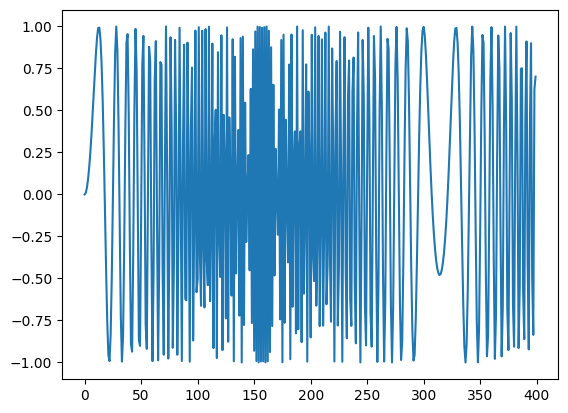

In [3]:
# plot it
plt.plot(series)
plt.show()

In [4]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390, 1)


In [5]:
### try autoregressive linear model
model = nn.Linear(T, 1)

In [6]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [7]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [8]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

In [9]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.5153, Test Loss: 0.6976
Epoch 10/200, Train Loss: 0.5113, Test Loss: 0.7076
Epoch 15/200, Train Loss: 0.4979, Test Loss: 0.5882
Epoch 20/200, Train Loss: 0.4920, Test Loss: 0.5589
Epoch 25/200, Train Loss: 0.4887, Test Loss: 0.5882
Epoch 30/200, Train Loss: 0.4872, Test Loss: 0.6246
Epoch 35/200, Train Loss: 0.4843, Test Loss: 0.5949
Epoch 40/200, Train Loss: 0.4853, Test Loss: 0.5784
Epoch 45/200, Train Loss: 0.4836, Test Loss: 0.5863
Epoch 50/200, Train Loss: 0.4839, Test Loss: 0.5996
Epoch 55/200, Train Loss: 0.4836, Test Loss: 0.5919
Epoch 60/200, Train Loss: 0.4835, Test Loss: 0.5820
Epoch 65/200, Train Loss: 0.4833, Test Loss: 0.5926
Epoch 70/200, Train Loss: 0.4834, Test Loss: 0.5931
Epoch 75/200, Train Loss: 0.4834, Test Loss: 0.5862
Epoch 80/200, Train Loss: 0.4833, Test Loss: 0.5900
Epoch 85/200, Train Loss: 0.4833, Test Loss: 0.5913
Epoch 90/200, Train Loss: 0.4833, Test Loss: 0.5888
Epoch 95/200, Train Loss: 0.4833, Test Loss: 0.5892
Epoch 100/200

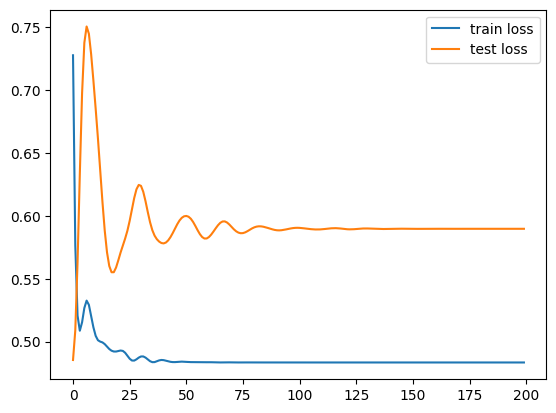

In [10]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [11]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
validation_target = Y[-N//2:]
with torch.no_grad():
  validation_predictions = model(X_test).numpy()
# validation_predictions = []

# # index of first validation input
# i = 0

# while len(validation_predictions) < len(validation_target):
#   input_ = X_test[i].reshape(1, -1)
#   p = model(input_)[0,0].item() # 1x1 array -> scalar
#   i += 1
  
#   # update the predictions list
#   validation_predictions.append(p)

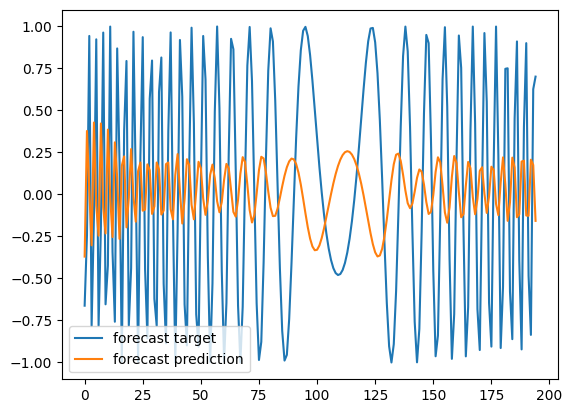

In [12]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [13]:
# Multi-step forecast (the correct way)
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, -1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

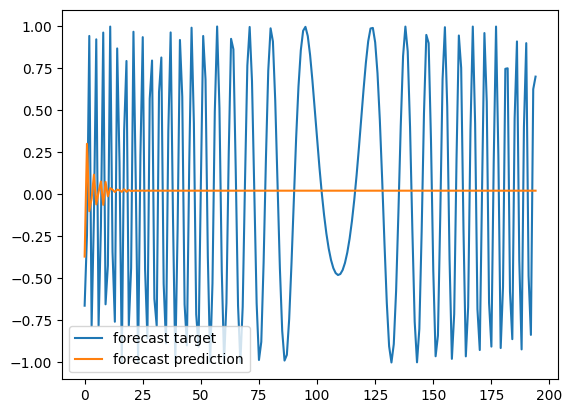

In [14]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()